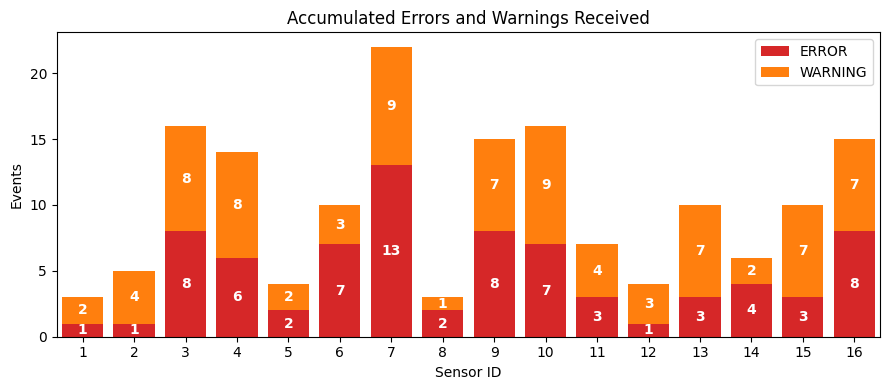

Stopped by user


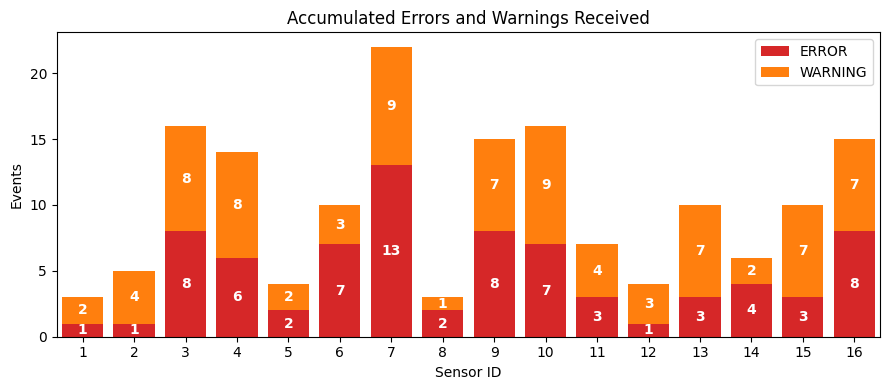

In [1]:
from IPython.display import clear_output, display
import json, time
from collections import Counter
import matplotlib.pyplot as plt
from confluent_kafka import Consumer

# --- Kafka configuration ---
conf = {
    "bootstrap.servers": "localhost:9092",
    "group.id": "log-vis-group",
    "auto.offset.reset": "latest",
}
consumer = Consumer(conf)
consumer.subscribe(["log-data"])

# --- In-memory counters ---
error_counts   = Counter()   # sensor_id -> number of ERRORs
warning_counts = Counter()   # sensor_id -> number of WARNINGs

# Create the figure ONCE
fig, ax = plt.subplots(figsize=(9, 4))

def update_plot():
    ax.clear()
    sensor_ids = sorted(set(error_counts) | set(warning_counts))
    errs  = [error_counts[s]   for s in sensor_ids]
    warns = [warning_counts[s] for s in sensor_ids]

    # stacked bars
    bars_err = ax.bar(sensor_ids, errs, label="ERROR",   color="tab:red")
    bars_wrn = ax.bar(sensor_ids, warns, bottom=errs, label="WARNING", color="tab:orange")

    # X-axis ticks and limits
    ax.set_xticks(sensor_ids)
    ax.set_xlim(0.5, 16.5)

    # Labels and title
    ax.set_xlabel("Sensor ID")
    ax.set_ylabel("Events")
    ax.set_title("Accumulated Errors and Warnings Received")
    ax.legend()

    # annotate each bar segment with its value
    for err_bar, wrn_bar, e, w in zip(bars_err, bars_wrn, errs, warns):
        # error count in the red segment
        ax.annotate(
            f"{e}",
            xy=(err_bar.get_x() + err_bar.get_width() / 2, e / 2),
            ha="center", va="center", color="white", fontweight="bold"
        )
        # warning count on top of the red
        ax.annotate(
            f"{w}",
            xy=(wrn_bar.get_x() + wrn_bar.get_width() / 2, e + w / 2),
            ha="center", va="center", color="white", fontweight="bold"
        )

    plt.tight_layout()


try:
    last_redraw = time.time()
    while True:
        msg = consumer.poll(0.2)
        if msg and msg.value():
            entry = json.loads(msg.value())
            sid, level = entry.get("sensor_id"), entry.get("level")
            if level == "ERROR":
                error_counts[sid]   += 1
            elif level == "WARNING":
                warning_counts[sid] += 1

        # redraw every second
        if time.time() - last_redraw >= 1.0:
            clear_output(wait=True)
            update_plot()
            display(fig)
            last_redraw = time.time()

except KeyboardInterrupt:
    print("Stopped by user")
finally:
    consumer.close()
